In [3]:
from abc import abstractmethod
from typing import Optional
import numpy as np
import pywt
from numpy.typing import NDArray
import os
import cv2
import pandas as pd
from skimage import color, io, measure
from matplotlib import pyplot as plt
from sklearn import metrics, preprocessing, linear_model

ModuleNotFoundError: No module named 'pywt'

In [ ]:
class CompressionTransform:
    @abstractmethod
    def forward(self, variables: NDArray) -> NDArray:
        ...
    @abstractmethod
    def backward(self, variables: NDArray) -> NDArray:
        ...
#transformacja Fourier
class FourierTransform2D(CompressionTransform):
    def forward(self, variables: NDArray) -> NDArray:
        return np.fft.fft2(variables)
    def backward(self, variables: NDArray) -> NDArray:
        return np.abs(np.fft.ifft2(variables))
#tranformacja falkowa 
class WaveletTransform2D(CompressionTransform):
    def __init__(self, wavelet_name: str, level: int):
        self.wavelet_name = wavelet_name
        self.level = level
        self.slices: Optional[NDArray] = None
    def forward(self, variables: NDArray) -> NDArray:
        transformed = pywt.wavedec2(variables, self.wavelet_name, level=self.level)
        coefficients, slices = pywt.coeffs_to_array(transformed)
        self.slices = slices

        return coefficients
    def backward(self, variables: NDArray) -> NDArray:
        if self.slices is None:
            raise ValueError("Cannot perform inverse transform without first performing forward transform!")

        variables = pywt.array_to_coeffs(variables, self.slices, output_format="wavedec2")  # type: ignore
        return pywt.waverec2(variables, self.wavelet_name)

def compress_and_decompress(image: NDArray, transform: CompressionTransform, compression: float) -> NDArray:
    transformed = transform.forward(image)
    coefficients = np.sort(np.abs(transformed.reshape(-1)))  # sort by magnitude

    threshold = coefficients[int(compression * len(coefficients))]
    indices = np.abs(transformed) > threshold

    decompressed = transformed * indices
    return transform.backward(decompressed)
def adaptive_compression(image: NDArray, transform: CompressionTransform, target_error: float = 0.01, max_iterations: int = 50) -> NDArray:
    compression = 1.0
    for i in range(max_iterations):
        decompressed_image = compress_and_decompress(image, transform, compression)
        error = np.mean(np.abs(image - decompressed_image))

        if error <= target_error:
            break
        #dostosuj kompresje
        compression *= 0.9  

    return decompressed_image

def apply_rgb(func: callable, image: NDArray, *args, **kwargs) -> NDArray:
    return np.dstack([func(image[:, :, channel], *args, **kwargs) for channel in range(3)])

(-0.5, 504.5, 358.5, -0.5)

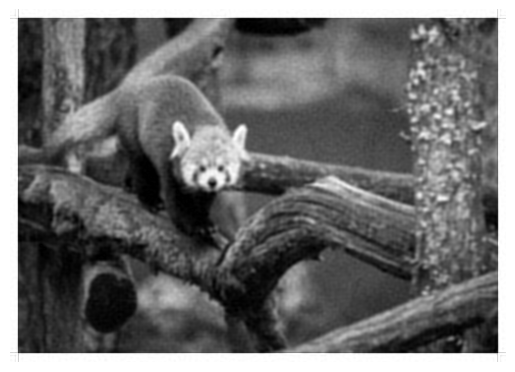

In [ ]:
#kompresja szary 1
image_path = "C:/Users/matiu/OneDrive/Pulpit/SIOC/lab4/szare/image.jpg"
image = cv2.imread(image_path)
decompressed_image = apply_rgb(compress_and_decompress, image, transform=FourierTransform2D(), compression=0.90)
plt.imshow(np.clip(decompressed_image.astype(int), 0, 255), cmap='gray')
plt.axis('off')

(-0.5, 854.5, 594.5, -0.5)

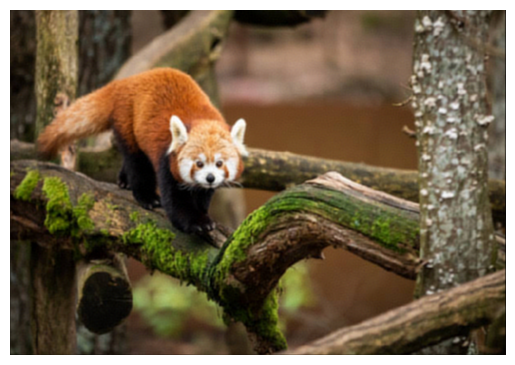

In [ ]:
#kompresja kolor 1
image_path = "C:/Users/matiu/OneDrive/Pulpit/SIOC/lab4/kolorowe/panda.jpg"
image1 = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
decompressed_image1 = apply_rgb(compress_and_decompress, image_rgb, transform=FourierTransform2D(), compression=0.90)
plt.imshow(np.clip(decompressed_image1.astype(int), 0, 255))
plt.axis('off')

(-0.5, 855.5, 595.5, -0.5)

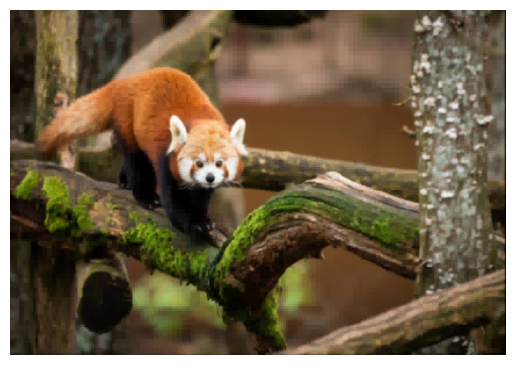

In [ ]:
#kompresja falka 
decompressed_image2 = apply_rgb(compress_and_decompress, image_rgb, transform=WaveletTransform2D(wavelet_name="db1", level=3), compression=0.95)
plt.imshow(np.clip(decompressed_image2.astype(int), 0, 255))
plt.axis('off')

(-0.5, 855.5, 595.5, -0.5)

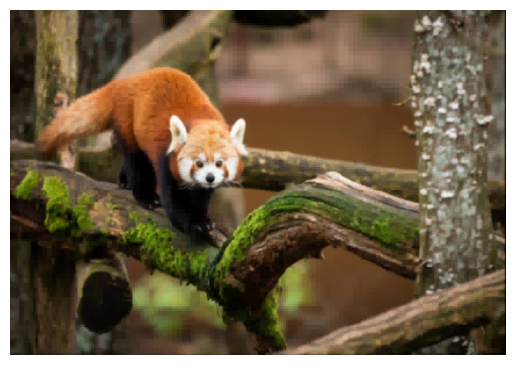

In [ ]:
#kompresja adaptacyjna 1 Falkowa
image_path = "C:/Users/matiu/OneDrive/Pulpit/SIOC/lab4/kolorowe/panda.jpg"
original_image = io.imread(image_path)
wavelet_transform = WaveletTransform2D(wavelet_name="db1", level=3)
adaptively_compressed_image = adaptive_compression(original_image, transform=wavelet_transform, target_error=0.01)

plt.imshow(np.clip(adaptively_compressed_image.astype(int), 0, 255))
plt.axis('off')

In [ ]:
folder_path = "C:/Users/matiu/OneDrive/Pulpit/SIOC/lab4/szare/"
images = {}

for image_path in os.listdir(folder_path):
    if image_path.endswith(".jpg"):
        full_path = os.path.join(folder_path, image_path)
        image = io.imread(full_path)
        name, suffix = os.path.splitext(image_path)
        images[name] = image
images.keys()

dict_keys(['circl', 'image'])

(-0.5, 639.5, 639.5, -0.5)

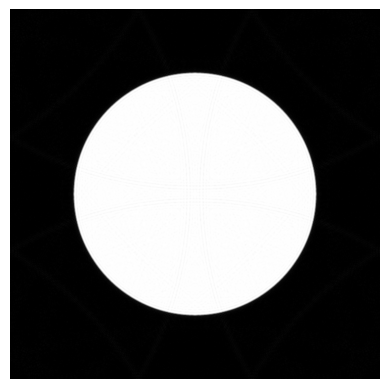

In [ ]:
#kompresja szary 2
decompressed_image = apply_rgb(compress_and_decompress, images["circl"], transform=FourierTransform2D(), compression=0.90)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(np.clip(decompressed_image.astype(int), 0, 255))
plt.axis('off')

In [ ]:
summary = []

for name, image in images.items():
    for compression in (0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.98, 0.99, 0.999):
        decompressed_image = apply_rgb(compress_and_decompress, image, transform=FourierTransform2D(), compression=compression)
        decompressed_image = np.clip(decompressed_image.astype(int), 0, 255)
        error = metrics.mean_absolute_error(y_true=image.flatten(), y_pred=decompressed_image.flatten()) / image.max()
        summary.append({"image": name, "compression": compression, "error": error})

In [ ]:
pd.DataFrame.from_dict(summary).head(10)

,image,compression,error
0,circl,0.000,0.000685
1,circl,0.100,0.000689
2,circl,0.300,0.001020
3,circl,0.500,0.002338
4,circl,0.700,0.003592
5,circl,0.900,0.005726
6,circl,0.950,0.007916
7,circl,0.980,0.011793
8,circl,0.990,0.015851
9,circl,0.999,0.039324


In [ ]:
images = {}

folder_path = "C:/Users/matiu/OneDrive/Pulpit/SIOC/lab4/kolorowe/"
images = {}

for image_path in os.listdir(folder_path):
    if image_path.endswith(".jpg"):
        full_path = os.path.join(folder_path, image_path)
        image = io.imread(full_path)
        name, suffix = os.path.splitext(image_path)
        images[name] = image
images.keys()

dict_keys(['czerwona', 'pand (1)', 'panda'])

(-0.5, 949.5, 759.5, -0.5)

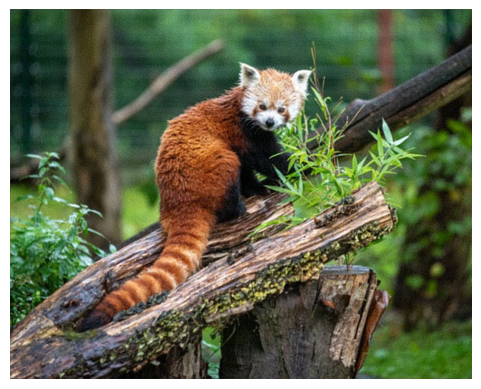

In [ ]:
#kompresja kolor 2
decompressed_image = apply_rgb(compress_and_decompress, images["czerwona"], transform=FourierTransform2D(), compression=0.90)
image_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.imshow(np.clip(decompressed_image.astype(int), 0, 255))
plt.axis('off')

In [ ]:
summary = []

for name, image in images.items():
    for compression in (0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.98, 0.99, 0.999):
        decompressed_image = apply_rgb(compress_and_decompress, image, transform=FourierTransform2D(), compression=compression)
        decompressed_image = np.clip(decompressed_image.astype(int), 0, 255)
        error = metrics.mean_absolute_error(y_true=image.flatten(), y_pred=decompressed_image.flatten()) / image.max()
        summary.append({"image": name, "compression": compression, "error": error})

In [ ]:
pd.DataFrame.from_dict(summary).head(10)

,image,compression,error
0,czerwona,0.000,0.001954
1,czerwona,0.100,0.002057
2,czerwona,0.300,0.004764
3,czerwona,0.500,0.008551
4,czerwona,0.700,0.013867
5,czerwona,0.900,0.025003
6,czerwona,0.950,0.032256
7,czerwona,0.980,0.042232
8,czerwona,0.990,0.050069
9,czerwona,0.999,0.075882


(-0.5, 949.5, 759.5, -0.5)

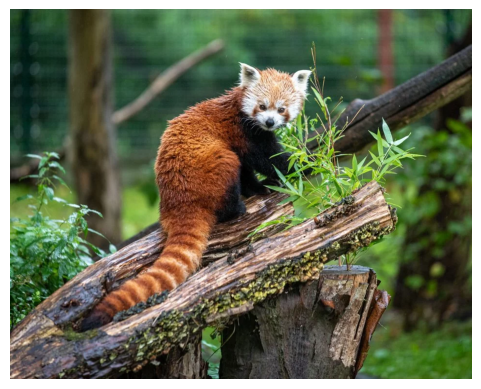

In [ ]:
#kompresja adaptacyjna 2 Fourier
images = {}
folder_path = "C:/Users/matiu/OneDrive/Pulpit/SIOC/lab4/kolorowe/"

for image_path in os.listdir(folder_path):
    if image_path.endswith(".jpg"):
        full_path = os.path.join(folder_path, image_path)
        image = io.imread(full_path)
        name, suffix = os.path.splitext(image_path)
        images[name] = image

#kompresja adaptacyjna 
decompressed_image3 = apply_rgb(adaptive_compression, images["czerwona"], transform=FourierTransform2D(), target_error=0.01,
    max_iterations=50)
plt.imshow(np.clip(decompressed_image3.astype(int), 0, 255))
plt.axis('off')